# Design of Experiments for Reaction Optimization

#### DOE in Reaction Optimization

Design of experiments is commonly utilized for the optimization of process parameters in chemistry. In general, an experimental design will be executed, the results used to build a model, and the model used to predict optimal conditions. However, the process of running DOE for a given system relies heavily on operator intuition and experience. What type of design to use? How to treat categorical variables? How to model responses? These questions and more require answers for a given application. In this demo, we will standardize this practice for the purposes of reproducibility and automation.

#### Experimental Design

In this notebook we benchmark DOE as an optimization methodology. The simulation design is: (1) run $M$ experiments associated with an experimental design, (2) train a quadratic model using the data, and (3) predict the $N = B - M$ best conditions (where $B$ is the number of experiments in the budget). Then the best observed yield distribution in the experimental data can be compared to Bayesian optimization (BO) using the same number of experiments. We will also take this time to go ahead and develop a general DOE framework compatible with edbo, as such methods could be quite useful for initializing BO.

Since many optimization reaction spaces are built from categorical variables, we will need to use designs compatible with this data type. For example, since response surface designs (e.g., central composite) require a sense of order and factorial designs require the use of only 2 levels, these designs are not readily adaptable to typical synthetic tasks. Hence DOE is typically only used for optimizations over continuous variables). 

**Fractional Factorial Design**. One design compatible with multilevel categorical variables is the *Generalized Subset Design* (GSD). GSD is a generalization of traditional fractional factorial designs to problems where factors can have more than two levels. **These designs were actually developed specifically for chemistry!**

*Citation:* https://pubs.acs.org/doi/10.1021/acs.analchem.7b00506

*Implementation:* https://github.com/clicumu/pyDOE2

**D-Optimal Design**. D-optimal designs are computer-aided designs which can be utilized when classical designs fail (e.g., reaction optimization with categorical variables). These designs have been employed effectively towards the optimization of chemical processes. We will employ Federov's exchange algorithm to calculate the approximate design for each reaction.


*Citation:* https://www.itl.nist.gov/div898/handbook/pri/section5/pri521.htm

*Example:* https://pubs.acs.org/doi/abs/10.1021/acs.oprd.8b00018

*Implementation:* https://www.rdocumentation.org/packages/AlgDesign/versions/1.2.0/topics/optFederov


**Modeling**. For the modeling we will utilize a polynomial model (up to quadratic terms) since this is typical in DOE as a means to capture interactions. We will OHE the data sets since most applications do not utilize chemical descriptors (Note that this method is fully compatible with any encoding though).


## Build Search Spaces

One point of variability in these types of designs, is that the ordering of the levels is arbitrary. That is, the design you end up with will depend upon the order in which you list the components in each category. This of course is not a desirable feature as different users may list their reagents in a different order for the same reaction space. Thus to gauge the variance in outcome to the ordering of the categorical variables we can simply shuffle the data.


In [1]:
# Imports

import pandas as pd
from edbo.utils import Data
from edbo.feature_utils import reaction_space
from data_loader import aryl_amination, suzuki

# Suzuki reaction data

class reaction1:
    """Suzuki data loader and component shuffling"""

    def __init__(self):

        # Load OHE data
        self.data = suzuki()
        
        # Components required for DOE
        self.components = {'electrophile':0,
                           'nucleophile':1,
                           'base':2,
                           'ligand':4,
                           'solvent':5}
    
    def shuffle(self, seed=0):
        """Suffle DataFrame using sampling."""
        
        rxn = Data(self.data.copy())
        
        # Shuffle to change ordering of variables    
        rxn.base_data = rxn.base_data.sample(len(rxn.base_data), random_state=seed).copy().reset_index(drop=True)
        rxn.data = rxn.base_data.copy()
    
        # Clean data
        rxn.clean()
        rxn.drop(['entry'])
    
        # Required for DOE function
        rxn.index_headers = ['electrophile_SMILES', 
                             'nucleophile_SMILES',
                             'base_SMILES',
                             'ligand_SMILES',
                             'solvent_SMILES']
    
        return rxn

# Aryl amination reaction data

class reaction2:
    """Aryl amination data loader and component shuffling"""

    def __init__(self, subset):

        # Load OHE data
        self.data = aryl_amination(subset=subset)
        
        # Components required for DOE
        self.components = {'aryl_halide':0,
                           'additive':1,
                           'base':2,
                           'ligand':4}
    
    def shuffle(self, seed=0):
        """Suffle DataFrame using sampling."""
        
        rxn = Data(self.data.copy())
        
        # Shuffle to change ordering of variables    
        rxn.base_data = rxn.base_data.sample(len(rxn.base_data), random_state=seed).copy().reset_index(drop=True)
        rxn.data = rxn.base_data.copy()
    
        # Clean data
        rxn.clean()
        rxn.drop(['entry'])
    
        # Required for DOE function
        rxn.index_headers = ['aryl_halide_SMILES', 
                             'additive_SMILES',
                             'base_SMILES',
                             'ligand_SMILES']
    
        return rxn

## Modeling

Linear or quadratic models are often used to model reaction response surfaces in order to gauge direct and interaction effects. Due to the large number of features associated with such an expansion we will also use automatic relevance determination to fit the weights of the regression model.

**Implementation:** https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html

As an additional demonstration of the versatility of *edbo*, we will write a model class that is compatible with the framework and then use *edbo* methods to carry out the modeling. We will use pyDOE2 to generate the GSD in python and AlgDesign to generate the D-optimal design in R (we will just read in a CSV). The python and R code for DOE functions in in the accompanying DOE.py and DOE.R files.


In [2]:
# Imports

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

from edbo.bro import BO
from edbo.acq_func import top_predicted

try:
    from DOE import generalized_subset_design, external_design
except Exception as e:
    print(e)
    !conda install -y -c conda-forge pydoe2
    from DOE import generalized_subset_design, external_design

# Polynomial regression model using ARD and grid search CV for training

class Polynomial_ARD_Model:
    """Bayesian linear polynomial regression object compatible with the BO framework."""
    
    def __init__(self, X, y, **kwargs):
        
        # CV set gamma prior parameters - no GS for now
        self.alphas = np.logspace(-6, 0.5, 7)
        
        # Initialize model
        self.model = ARDRegression(n_iter=50)
        
        # Make sure X and y are numpy arrays
        self.X = np.array(X)
        self.y = np.array(y)
        
        # Polynomial expansion
        self.expander = PolynomialFeatures(2)
        self.X = self.expander.fit_transform(self.X)
        
    # Fit    
    def fit(self):
        """Train the model using grid search CV.""" 
        
        parameters = [{'alpha_1': self.alphas, 'alpha_2': self.alphas}]
        
        # Set the number of folds
        if len(self.X) < 5:
            n_folds = len(self.X)
        else:
            n_folds = 5
        
        # Run grid search
        if n_folds > 1:
        
            # Select l1 term via grid search
            self.grid_search = GridSearchCV(self.model, 
                                       parameters, 
                                       cv=n_folds, 
                                       refit=True,
                                       n_jobs=-1)
        
            self.grid_search.fit(self.X, self.y)
        
            # Set model to trained model
            self.model = self.grid_search.best_estimator_
        
        # Just fit model
        else:
            self.model.fit(self.X, self.y)
            
    def get_scores(self):
        """Get grid search cross validation results.""" 
        
        # Plot results
        scores = self.grid_search.cv_results_['mean_test_score']
        scores_std = self.grid_search.cv_results_['std_test_score']
        
        return scores, scores_std
        
    # Predict   
    def predict(self, points):
        """Model predictions.""" 
        
        # Make sure points in a numpy array
        points = np.array(points)
        
        # Expand
        points = self.expander.fit_transform(points)
        
        # Make predicitons
        pred = self.model.predict(points)
        
        return pred
        
    # Regression   
    def regression(self, return_data=False, export_path=None, return_scores=False):
        """Helper method for visualizing the models regression performance."""

        pred = self.predict(self.X)
        obs = self.y        
        return pred_obs(pred, 
                        obs, 
                        return_data=return_data, 
                        export_path=export_path,
                        return_scores=return_scores) 
    
    # Estimate variance
    def variance(self, points):
        """Estimated variance of Bayesian linear model."""
        
        # Make sure points in a numpy array
        points = np.array(points)
        
        # Expand
        points = self.expander.fit_transform(points)
        
        # Make predicitons
        pred, std = self.model.predict(points, return_std=True)
        
        return std**2

# DOE testing function utilizing edbo framework

def doe_optimization(reaction, seed, reduction=21, budget=50, design='gsd', external=None):
    """
    Run a design, fit a quadratic model and use the remainder of the 
    experimental budget to evaluate the top predicted experiments.
    """

    # Data
    space = reaction.shuffle(seed)

    # DOE
    if design == 'gsd':
        # Choose a reduction which gets closest to but is <= a budget of 50 experiments
        designer = generalized_subset_design(space, reaction.components)
        designer.build(reduction=reduction)
    elif design == 'external':
        designer = external_design(space, reaction.components, external)
    
    designer.get_experiments()              # Fetch corresponding experiments
    designer.encoded()                      # Fetch encoded experiments
    
    # Use BO to model
    bo = BO(domain=space.data.drop('yield', axis=1),       # Domain
            exindex=space.data,                            # Result index
            results=designer.encoded_design,               # DOE results
            acquisition_function='rand',                   # Random acquisition just to train the model
            batch_size=50 - len(designer.encoded_design),  # Number of points to choose using model                            
            fast_comp=True,                                # Use fast computation features
            init_method='external',                        # Initialization from results
            model=Polynomial_ARD_Model)                    # Polynomial model
    
    # Train model
    bo.run()
    
    # Get top predicted points
    top = top_predicted(bo.batch_size, False)
    best = top.run(bo.model, bo.obj)
    bo.obj.get_results(best, append=True)
    
    # Get max observed yield
    maximum = bo.obj.results_input()['yield'].max()
    
    # Model fit
    r2 = bo.model.model.score(bo.model.X, bo.model.y)
    
    # Reporting
    print('Seed:', seed, '|',
          'Design size:', len(designer.design), '|',
          'Fit R^2:', r2, '|',
          'DOE max:', bo.obj.results_input().iloc[:-bo.batch_size]['yield'].max(), '|',
          'Max:', bo.obj.results_input()['yield'].max(), '|',
          'Ground truth:', bo.obj.exindex['yield'].max(),
          )
    
    return designer, bo, maximum

### Generalized Subset Design Test 

Generate a Generalized Subset Design from encoded reaction data, fit a model, select best points, report results.

In [3]:
# Data
reaction = reaction2(1)

# DOE + optimization
designer, bo, maximum = doe_optimization(reaction, 1, reduction=21, budget=50)

Seed: 1 | Design size: 44 | Fit R^2: 0.9983808243158707 | DOE max: 54.24578847 | Max: 54.24578847 | Ground truth: 55.56585889


Check out the designs.

In [4]:
designer.design.head()

,aryl_halide,additive,base,ligand
0,0,0,0,0
1,0,21,0,0
2,0,0,1,1
3,0,21,1,1
4,0,0,2,2


In [5]:
designer.experiment_design.head()

,aryl_halide,additive,base,ligand
0,FC(F)(F)c1ccc(I)cc1,Cc1ccon1,CN(C)/C(N(C)C)=N\C(C)(C)C,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=CC=CC=C2P(C(C...
1,FC(F)(F)c1ccc(I)cc1,COC(=O)c1cc(on1)c2sccc2,CN(C)/C(N(C)C)=N\C(C)(C)C,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=CC=CC=C2P(C(C...
2,FC(F)(F)c1ccc(I)cc1,Cc1ccon1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C(C)(C)C)...
3,FC(F)(F)c1ccc(I)cc1,COC(=O)c1cc(on1)c2sccc2,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C(C)(C)C)...
4,FC(F)(F)c1ccc(I)cc1,Cc1ccon1,CN1CCCN2CCCN=C12,CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C3CCCCC3)...


In [6]:
designer.encoded_design.head()

,aryl_halide=FC(F)(F)c1ccc(Cl)cc1,aryl_halide=FC(F)(F)c1ccc(Br)cc1,aryl_halide=FC(F)(F)c1ccc(I)cc1,additive=o1cc(cn1)c2ccccc2,additive=o1nccc1c2ccccc2,additive=o1ccc(n1)c2ccccc2,additive=CCOC(=O)c1onc(C)c1,additive=Cc1ccon1,additive=CCOC(=O)c1cc(C)on1,additive=Cc1oncc1,...,additive=COC(=O)c1cc(on1)c2sccc2,additive=CCOC(=O)c1onc(OC)c1,base=CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,base=CN(C)/C(N(C)C)=N\C(C)(C)C,base=CN1CCCN2CCCN=C12,ligand=CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2,ligand=CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=CC=CC=C2P(C(C)(C)C)C(C)(C)C,ligand=CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C(C)(C)C)C(C)(C)C)C(OC)=CC=C2OC,ligand=CC(C1=C(C2=C(OC)C=CC(OC)=C2P(C34CC5CC(C4)CC(C5)C3)C67CC8CC(C7)CC(C8)C6)C(C(C)C)=CC(C(C)C)=C1)C,yield
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,52.378114
189,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,37.377944
702,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,28.581966
242,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,32.359588
123,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,47.428704


Plot the model's fit to the training data and the full reaction space.

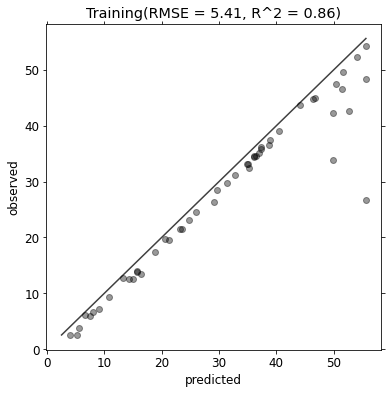

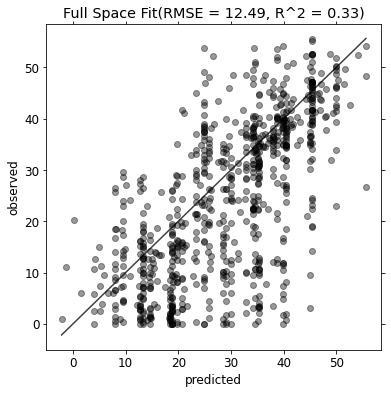

In [7]:
from edbo.plot_utils import pred_obs

pred = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.results.drop('yield', axis=1).values))
obs = bo.obj.results_input()['yield'].values
pred_obs(pred, obs, title='Training')

pred = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain.values))
obs = bo.obj.exindex['yield'].values
pred_obs(pred, obs, title='Full Space Fit')

### D-Optimal Design Test 

Generate a D-optimal design using R, fit a model, select best points, report results.

In [9]:
# Data
reaction = reaction1()

# D-optimal design from R
external = pd.read_csv('R_doptimal/suzuki_d-optimal.csv').iloc[:,1:] - 1 # Adjust for python indices

# DOE + optimization
designer, bo, maximum = doe_optimization(reaction, 3, budget=50, design='external', external=external)

KeyError: 'Electrophile_SMILES'

Check out the designs.

In [ ]:
designer.design.head()

In [ ]:
designer.experiment_design.head()

In [ ]:
designer.encoded_design.head()

Plot the model's fit to the training data and the full reaction space.

In [ ]:
from edbo.plot_utils import pred_obs

pred = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.results.drop('yield', axis=1).values))
obs = bo.obj.results_input()['yield'].values
pred_obs(pred, obs, title='Training')

pred = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain.values))
obs = bo.obj.exindex['yield'].values
pred_obs(pred, obs, title='Full Space Fit')

## Simulations & Statistics

Now to gauge the variance in outcome to the ordering of the categorical variables we will run DOE based optimizations on each of the six development sets with 20 different random shuffling. To do this we can write a simulation function based on the modeling functions.


In [10]:
# Simulation function

def simulation(reaction, rounds, reduction=21, budget=50, design='gsd', external=None):

    i = 0
    count = 0
    maxs = []
    results = []
    
    while count < rounds:
        # Some data sets are missing a few values which leads to an exception when fetching results
        try:
            designer, bo, maximum = doe_optimization(reaction, i, reduction=reduction, budget=budget, design=design, external=external)
            result = list(bo.obj.results_input()['yield'].values)
            
            # Try not to end up with the same experimental design twice
            if result not in results:
                results.append(result)
                maxs.append(maximum)
                count += 1
                i += 1
            else:
                i += 1
        except:
            i += 1
            pass
        
    return results, maxs

Then with the optimization outcome distributions in hand we can compute some test statistics to evaluate the performance of BO versus DOE in the optimization of the 6 development reactions with the same experimental budget. To do this, we will conduct a hypothesis test under the null hypothesis that the central tendency of BO and DOE performance is identical. Here, we remove the assumption of equal variance between the two population samples and utilize an unpaired Welch’s t-test with Satterthwait degrees of freedom.

In [11]:
import matplotlib.pyplot as plt

# Statistics functions

try: 
    import statsmodels.stats.api as sms
except:
    !conda install -y statsmodels
    import statsmodels.stats.api as sms

# Welsh's t-test    

def t_test(X1, X2, sample_vars='equal', print_out=True):
    """
    t-test for the null hypothesis of identical means. The unpaired 
    t-test should not be used if there is a significant difference 
    between the variances of the two samples. Here, if the variance
    of the samples is not assumed to be the same, then Welsh t-test 
    with Satterthwait degrees of freedom is used.
    """
    
    if sample_vars == 'equal':
        usevar = 'pooled'
    else:
        usevar = 'unequal'
        
    cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    ci = cm.tconfint_diff(usevar=usevar)
    t_value = cm.ttest_ind(usevar=usevar)
    
    if print_out == True:
        print('95% CI:', ci)
        print('DOF:', t_value[2])
        print('t-stat:', t_value[0])
        print('p-value:', t_value[1])
        
    return [t_value[2], t_value[0], t_value[1], ci[0], ci[1]]

# Report summary statistics    

def statistic_summary(bo_maxs, doe_maxs, export_path=None):
    """Distributional and statistical summary."""
    
    # Disributions
    plt.figure(figsize=(5,5))
    
    plt.hist(bo_maxs, alpha=0.5, label='Bayesian Optimization')
    plt.hist(doe_maxs, alpha=0.5, label='DOE Optimization')
    plt.legend(loc='upper left')
    plt.xlabel('Max Observed Yield')
    plt.ylabel('Count')
    
    if export_path is not None:
        plt.savefig(export_path + '.svg', format='svg', dpi=1200, bbox_inches='tight')
        plt.show()
    else:
        plt.show()
    
    # Statistics
    print('\n') 
    print('---------------------------------------')
    print('-------------Distributions-------------')
    print('---------------------------------------')
    print('BO Mean:', sum(bo_maxs)/len(bo_maxs), '|', 'DOE Mean:', sum(doe_maxs)/len(doe_maxs))
    print('BO STD:',  np.array(bo_maxs).std(),   '|', 'DOE STD:',  np.array(doe_maxs).std())
    print('BO Min:',  min(bo_maxs), '|', 'DOE Min:',  min(doe_maxs))
    print('\n') 
    print('---------------------------------------')
    print('---Hypothesis Test: MeanBO = MeanDOE---')
    print('---------------------------------------')
    print('BO Mean - DOE Mean:', sum(bo_maxs)/len(bo_maxs) - sum(doe_maxs)/len(doe_maxs))
    t = t_test(bo_maxs, doe_maxs, sample_vars='unequal')
    
    dist = [sum(bo_maxs)/len(bo_maxs) - sum(doe_maxs)/len(doe_maxs),
            np.array(bo_maxs).std() - np.array(doe_maxs).std(),
            min(bo_maxs) - min(doe_maxs)]
    
    columns = ['BO Mean - DOE Mean', 'BO STD - DOE STD', 'BO Min - DOE Min', 'DOF', 't-stat', 'p-value', 'CI95 Lower', 'CI95 Upper']
    
    return pd.DataFrame([dist + t], columns=columns)

Load BO simulation results.

In [12]:
# BO results

paths = ['simulation_results/Suz_bs=5_rand_GP-EI.csv',
         'simulation_results/CNar1_bs=5_rand_GP-EI.csv',
         'simulation_results/CNar2_bs=5_rand_GP-EI.csv',
         'simulation_results/CNar3_bs=5_rand_GP-EI.csv',
         'simulation_results/CNar4_bs=5_rand_GP-EI.csv',
         'simulation_results/CNar5_bs=5_rand_GP-EI.csv']

bo_results = {}
bo_maxs = {}
for path, key in zip(paths,['reaction1', 'reaction2a', 'reaction2b', 'reaction2c', 'reaction2d', 'reaction2e']):
    result = pd.read_csv(path, index_col=0)
    bo_results[key] = result
    bo_maxs[key] = result.max(axis=1).values

FileNotFoundError: [Errno 2] No such file or directory: 'simulation_results/Suz_bs=5_rand_GP-EI.csv'

### Generalized Subset Design Simulations 

**Reaction 1**

In [13]:
PATH = 'simulation_results/'

# Data
reaction = reaction1()
name = PATH + 'Suzuki_GSD_Poly_ARD_Model'

# Simulation
results1, maxs1 = simulation(reaction, 20, reduction=19, budget=50)
pd.DataFrame(results1).to_csv(name + '.csv')

r1 = statistic_summary(bo_maxs['reaction1'], maxs1, export_path='simulation_results/Suzuki_hist_GSD')

KeyError: 'Electrophile_SMILES'

**Reaction 2a**

In [14]:
# Data
reaction = reaction2(1)
name = PATH + 'CNar1_GSD_Poly_ARD_Model'

# Simulation
results2a, maxs2a = simulation(reaction, 20, reduction=21, budget=50)
pd.DataFrame(results2a).to_csv(name + '.csv')

r2a = statistic_summary(bo_maxs['reaction2a'], maxs2a, export_path='simulation_results/CNar1_hist_GSD')

Seed: 1 | Design size: 44 | Fit R^2: 0.9983808243158707 | DOE max: 54.24578847 | Max: 54.24578847 | Ground truth: 55.56585889
Seed: 2 | Design size: 44 | Fit R^2: 0.9999272380918603 | DOE max: 53.83922891 | Max: 53.83922891 | Ground truth: 55.56585889
Seed: 3 | Design size: 44 | Fit R^2: 0.9969218276596375 | DOE max: 47.09445645 | Max: 49.46796695 | Ground truth: 55.56585889
Seed: 4 | Design size: 44 | Fit R^2: 0.9996679614154397 | DOE max: 55.56585889 | Max: 55.56585889 | Ground truth: 55.56585889
Seed: 6 | Design size: 44 | Fit R^2: 0.9952104411952084 | DOE max: 52.49415636 | Max: 55.16379105 | Ground truth: 55.56585889
Seed: 7 | Design size: 44 | Fit R^2: 0.9579829183599162 | DOE max: 52.67302388 | Max: 52.67302388 | Ground truth: 55.56585889
Seed: 8 | Design size: 44 | Fit R^2: 0.939910650283005 | DOE max: 52.49415636 | Max: 52.49415636 | Ground truth: 55.56585889
Seed: 9 | Design size: 44 | Fit R^2: 0.9426334754091218 | DOE max: 54.22375463 | Max: 54.22375463 | Ground truth: 55.56

FileNotFoundError: [Errno 2] No such file or directory: 'simulation_results/CNar1_GSD_Poly_ARD_Model.csv'

**Reaction 2b**

In [15]:
# Data
reaction = reaction2(2)
name = PATH + 'CNar2_GSD_Poly_ARD_Model'

# Simulation
results2b, maxs2b = simulation(reaction, 20, reduction=21, budget=50)
pd.DataFrame(results2b).to_csv(name + '.csv')

r2b = statistic_summary(bo_maxs['reaction2b'], maxs2b, export_path='simulation_results/CNar2_hist_GSD')

Seed: 0 | Design size: 44 | Fit R^2: 0.9995584902264257 | DOE max: 57.87284649 | Max: 66.26538653 | Ground truth: 68.2481271
Seed: 1 | Design size: 44 | Fit R^2: 0.9490178359264462 | DOE max: 57.53990104 | Max: 68.2481271 | Ground truth: 68.2481271
Seed: 2 | Design size: 44 | Fit R^2: 0.9724845882497991 | DOE max: 54.23706048 | Max: 54.23706048 | Ground truth: 68.2481271
Seed: 3 | Design size: 44 | Fit R^2: 0.9978137304119512 | DOE max: 52.0133379 | Max: 52.0133379 | Ground truth: 68.2481271
Seed: 4 | Design size: 44 | Fit R^2: 0.9977964675244544 | DOE max: 52.0133379 | Max: 52.0133379 | Ground truth: 68.2481271
Seed: 5 | Design size: 44 | Fit R^2: 0.9925706042793946 | DOE max: 57.7087314 | Max: 68.2481271 | Ground truth: 68.2481271
Seed: 6 | Design size: 44 | Fit R^2: 0.9489244224811645 | DOE max: 66.26538653 | Max: 68.2481271 | Ground truth: 68.2481271
Seed: 7 | Design size: 44 | Fit R^2: 0.9979982285335662 | DOE max: 66.26538653 | Max: 68.2481271 | Ground truth: 68.2481271
Seed: 8 |

FileNotFoundError: [Errno 2] No such file or directory: 'simulation_results/CNar2_GSD_Poly_ARD_Model.csv'

**Reaction 2c**

In [16]:
# Data
reaction = reaction2(3)
name = PATH + 'CNar3_GSD_Poly_ARD_Model'

# Simulation
results2c, maxs2c = simulation(reaction, 20, reduction=21, budget=50)
pd.DataFrame(results2c).to_csv(name + '.csv')

r2c = statistic_summary(bo_maxs['reaction2c'], maxs2c, export_path='simulation_results/CNar3_hist_GSD')

Seed: 0 | Design size: 44 | Fit R^2: 0.9536535337040833 | DOE max: 75.71719698 | Max: 85.89473594 | Ground truth: 86.59757822
Seed: 3 | Design size: 44 | Fit R^2: 0.9652410091812248 | DOE max: 86.59757822 | Max: 86.59757822 | Ground truth: 86.59757822
Seed: 5 | Design size: 44 | Fit R^2: 0.9993560229726094 | DOE max: 81.47790375 | Max: 83.05466982 | Ground truth: 86.59757822
Seed: 6 | Design size: 44 | Fit R^2: 0.9346415959941263 | DOE max: 83.09647392 | Max: 83.09647392 | Ground truth: 86.59757822
Seed: 7 | Design size: 44 | Fit R^2: 0.9252523439586622 | DOE max: 85.89473594 | Max: 85.89473594 | Ground truth: 86.59757822
Seed: 8 | Design size: 44 | Fit R^2: 0.9522703242453486 | DOE max: 79.73976585 | Max: 80.78664078 | Ground truth: 86.59757822
Seed: 10 | Design size: 44 | Fit R^2: 0.9695640529474148 | DOE max: 75.06056887 | Max: 75.06056887 | Ground truth: 86.59757822
Seed: 11 | Design size: 44 | Fit R^2: 0.961684164764786 | DOE max: 83.29437838 | Max: 83.93941968 | Ground truth: 86.

FileNotFoundError: [Errno 2] No such file or directory: 'simulation_results/CNar3_GSD_Poly_ARD_Model.csv'

**Reaction 2d**

In [17]:
# Data
reaction = reaction2(4)
name = PATH + 'CNar4_GSD_Poly_ARD_Model'

# Simulation
results2d, maxs2d = simulation(reaction, 20, reduction=21, budget=50)
pd.DataFrame(results2d).to_csv(name + '.csv')

r2d = statistic_summary(bo_maxs['reaction2d'], maxs2d, export_path='simulation_results/CNar4_hist_GSD')

Seed: 0 | Design size: 44 | Fit R^2: 0.9356171399376965 | DOE max: 93.31083413 | Max: 98.17713445 | Ground truth: 99.99999
Seed: 1 | Design size: 44 | Fit R^2: 0.9548222040816422 | DOE max: 99.03446213 | Max: 99.61910732 | Ground truth: 99.99999
Seed: 2 | Design size: 44 | Fit R^2: 0.9490213906673842 | DOE max: 90.22793001 | Max: 98.84920594 | Ground truth: 99.99999
Seed: 3 | Design size: 44 | Fit R^2: 0.9963537611667832 | DOE max: 87.75322874 | Max: 92.35381549 | Ground truth: 99.99999
Seed: 4 | Design size: 44 | Fit R^2: 0.9507125649944296 | DOE max: 92.91423383 | Max: 97.56849953 | Ground truth: 99.99999
Seed: 5 | Design size: 44 | Fit R^2: 0.9601560386077823 | DOE max: 91.13914928 | Max: 95.38648822 | Ground truth: 99.99999
Seed: 6 | Design size: 44 | Fit R^2: 0.9533610213779034 | DOE max: 89.47412112 | Max: 96.13228316 | Ground truth: 99.99999
Seed: 7 | Design size: 44 | Fit R^2: 0.9516010630795971 | DOE max: 92.35381549 | Max: 95.38648822 | Ground truth: 99.99999
Seed: 8 | Design

FileNotFoundError: [Errno 2] No such file or directory: 'simulation_results/CNar4_GSD_Poly_ARD_Model.csv'

**Reaction 2e**

In [18]:
# Data
reaction = reaction2(5)
name = PATH + 'CNar5_GSD_Poly_ARD_Model'

# Simulation
results2e, maxs2e = simulation(reaction, 20, reduction=21, budget=50)
pd.DataFrame(results2e).to_csv(name + '.csv')

r2e = statistic_summary(bo_maxs['reaction2e'], maxs2e, export_path='simulation_results/CNar5_hist_GSD')

Seed: 0 | Design size: 44 | Fit R^2: 0.9987097164084155 | DOE max: 86.89971677 | Max: 86.89971677 | Ground truth: 98.73132029
Seed: 2 | Design size: 44 | Fit R^2: 0.9974506069990406 | DOE max: 88.35188783 | Max: 93.74857618 | Ground truth: 98.73132029
Seed: 3 | Design size: 44 | Fit R^2: 0.9501372077700911 | DOE max: 92.12702212 | Max: 93.58777419 | Ground truth: 98.73132029
Seed: 4 | Design size: 44 | Fit R^2: 0.9419862173784432 | DOE max: 93.58777419 | Max: 93.58777419 | Ground truth: 98.73132029
Seed: 6 | Design size: 44 | Fit R^2: 0.99891349063642 | DOE max: 86.08980917 | Max: 94.54981251 | Ground truth: 98.73132029
Seed: 7 | Design size: 44 | Fit R^2: 0.9752903826570345 | DOE max: 98.28722602 | Max: 98.28722602 | Ground truth: 98.73132029
Seed: 8 | Design size: 44 | Fit R^2: 0.9971205586830167 | DOE max: 81.55614964 | Max: 82.40046293 | Ground truth: 98.73132029
Seed: 9 | Design size: 44 | Fit R^2: 0.9276665271674573 | DOE max: 94.34623373 | Max: 94.34623373 | Ground truth: 98.731

FileNotFoundError: [Errno 2] No such file or directory: 'simulation_results/CNar5_GSD_Poly_ARD_Model.csv'

**Summary**

For each of the reactions in the development set you can see that the GSD baed DOE optimization was able to identify the global maximum in some instances. However, upon the shuffling of levels there was a considerable amount of variance in outcome observed. Therefore, while the difference in mean optimization outcome between the two methods are small in some instances (e.g., reaction 2d), the difference between the worst case outcomes was singificantly larger. For each reaction, the statistics tell us: (1) BO performs better on average (p-values < 0.05 in all cases), (2) BO has less variance in outcome even with randomly selected initial conditions, and (3) BO has a better worst case scenario (close to the global max yield).

In [ ]:
summary = pd.concat([r1, r2a, r2b, r2c, r2d, r2e]).reset_index(drop=True)
summary.insert(0, 'Reaction', ['1', '2a', '2b', '2c', '2d', '2e'])
summary.to_csv('simulation_results/gsd_summary.csv', index=False)
summary

### D-Optimal Design Simulations 

**Reaction 1**

In [19]:
PATH = 'simulation_results/'

# Data
reaction = reaction1()
name = PATH + 'Suzuki_DOpt_Poly_ARD_Model'

# D-optimal design from R
external = pd.read_csv('R_doptimal/suzuki_d-optimal.csv').iloc[:,1:] - 1 # Adjust for python indices

# Simulation
results1, maxs1 = simulation(reaction, 20, budget=50, design='external', external=external)
pd.DataFrame(results1).to_csv(name + '.csv')

r1 = statistic_summary(bo_maxs['reaction1'], maxs1, export_path='simulation_results/Suzuki_hist_DOpt')

KeyError: 'Electrophile_SMILES'

**Reaction 2a**

In [20]:
# Data
reaction = reaction2(1)
name = PATH + 'CNar1_DOpt_Poly_ARD_Model'

# D-optimal design from R
external = pd.read_csv('R_doptimal/amination_d-optimal.csv').iloc[:,1:] - 1 # Adjust for python indices

# Simulation
results2a, maxs2a = simulation(reaction, 20, budget=50, design='external', external=external)
pd.DataFrame(results2a).to_csv(name + '.csv')

r2a = statistic_summary(bo_maxs['reaction2a'], maxs2a, export_path='simulation_results/CNar1_hist_DOpt')

Seed: 0 | Design size: 45 | Fit R^2: 0.9586812650238765 | DOE max: 51.75674767 | Max: 55.16379105 | Ground truth: 55.56585889
Seed: 1 | Design size: 45 | Fit R^2: 0.9999723896868685 | DOE max: 54.24578847 | Max: 55.16379105 | Ground truth: 55.56585889
Seed: 2 | Design size: 45 | Fit R^2: 0.9967361237639185 | DOE max: 53.59986981 | Max: 55.16379105 | Ground truth: 55.56585889
Seed: 3 | Design size: 45 | Fit R^2: 0.9999953232238137 | DOE max: 50.13634297 | Max: 52.37811419 | Ground truth: 55.56585889
Seed: 4 | Design size: 45 | Fit R^2: 0.9999955265531147 | DOE max: 54.22375463 | Max: 54.22375463 | Ground truth: 55.56585889
Seed: 6 | Design size: 45 | Fit R^2: 0.9999464669521015 | DOE max: 52.58811564 | Max: 55.16379105 | Ground truth: 55.56585889
Seed: 7 | Design size: 45 | Fit R^2: 0.9999979645643793 | DOE max: 46.14092963 | Max: 52.67302388 | Ground truth: 55.56585889
Seed: 9 | Design size: 45 | Fit R^2: 0.9999860591623831 | DOE max: 52.55061961 | Max: 52.55061961 | Ground truth: 55.5

FileNotFoundError: [Errno 2] No such file or directory: 'simulation_results/CNar1_DOpt_Poly_ARD_Model.csv'

**Reaction 2b**

In [ ]:
# Data
reaction = reaction2(2)
name = PATH + 'CNar2_DOpt_Poly_ARD_Model'

# D-optimal design from R
external = pd.read_csv('R_doptimal/amination_d-optimal.csv').iloc[:,1:] - 1 # Adjust for python indices

# Simulation
results2b, maxs2b = simulation(reaction, 20, budget=50, design='external', external=external)
pd.DataFrame(results2b).to_csv(name + '.csv')

r2b = statistic_summary(bo_maxs['reaction2b'], maxs2b, export_path='simulation_results/CNar2_hist_DOpt')

**Reaction 2c**

In [ ]:
# Data
reaction = reaction2(3)
name = PATH + 'CNar3_DOpt_Poly_ARD_Model'

# D-optimal design from R
external = pd.read_csv('R_doptimal/amination_d-optimal.csv').iloc[:,1:] - 1 # Adjust for python indices

# Simulation
results2c, maxs2c = simulation(reaction, 20, budget=50, design='external', external=external)
pd.DataFrame(results2c).to_csv(name + '.csv')

r2c = statistic_summary(bo_maxs['reaction2c'], maxs2c, export_path='simulation_results/CNar3_hist_DOpt')

**Reaction 2d**

In [ ]:
# Data
reaction = reaction2(4)
name = PATH + 'CNar4_DOpt_Poly_ARD_Model'

# D-optimal design from R
external = pd.read_csv('R_doptimal/amination_d-optimal.csv').iloc[:,1:] - 1 # Adjust for python indices

# Simulation
results2d, maxs2d = simulation(reaction, 20, budget=50, design='external', external=external)
pd.DataFrame(results2d).to_csv(name + '.csv')

r2d = statistic_summary(bo_maxs['reaction2d'], maxs2d, export_path='simulation_results/CNar4_hist_DOpt')

**Reaction 2e**

In [ ]:
# Data
reaction = reaction2(5)
name = PATH + 'CNar5_DOpt_Poly_ARD_Model'

# D-optimal design from R
external = pd.read_csv('R_doptimal/amination_d-optimal.csv').iloc[:,1:] - 1 # Adjust for python indices

# Simulation
results2e, maxs2e = simulation(reaction, 20, budget=50, design='external', external=external)
pd.DataFrame(results2e).to_csv(name + '.csv')

r2e = statistic_summary(bo_maxs['reaction2e'], maxs2e, export_path='simulation_results/CNar5_hist_DOpt')

**Summary**

For each of the reactions in the development set you can see that the D-Optimal DOE optimization was able to identify the global maximum in some or many instances. However, upon the shuffling of levels there was a considerable amount of variance in outcome observed. Therefore, while the difference in mean optimization outcome between the two methods is small and not statistically significant in the case of reaction 2b, the difference between the worst-case outcomes was still large. For each reaction, the statistics tell us: (1) BO performs somewhat better on average (p-values < 0.05 in 5 out of 6 cases), (2) BO has less variance in outcome even with randomly selected initial conditions and more simulations, and (3) BO has a better worst case scenario (close to the global max yield).


In [ ]:
summary = pd.concat([r1, r2a, r2b, r2c, r2d, r2e]).reset_index(drop=True)
summary.insert(0, 'Reaction', ['1', '2a', '2b', '2c', '2d', '2e'])
summary.to_csv('simulation_results/dopt_summary.csv', index=False)
summary